### Упражнение 2

Решите [задачу](https://www.kaggle.com/rodolfomendes/abalone-dataset#abalone.csv) предсказания возраста морских ушек с помощью деревьев решений. 

1. Рассмотрите задачу и как классификацию, и как регрессию. 

- Попробуйте разные методы регуляризации: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `max_leaf_nodes`, `min_impurity_decrease`, `min_impurity_split`, `ccp_alpha`. Достаточно применить перечисленные методы по отдельности.

- Для обучения классификатора попробуйте опции `class_weight='balanced'` и `class_weight=None`.

- Измерьте R2 на тестовой выборке.

Можете использовать EDA, выложенные на Kaggle.

Имеет ли смысл экспериментировать с кодированием категориального признака `'Sex'`? Имеет ли смысл подвергать преобразованиям числовые признаки? Обоснуйте ответ.

#### Регрессия

In [129]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [130]:
train_df.shape

(2677, 9)

In [131]:
test_df.shape

(1500, 9)

In [132]:
#объединим данные для более подробного рассмотрения
new_data = pd.concat([train_df, test_df])

In [133]:
#сделаем копию фрейма
new_data_x200 = new_data.copy()

In [134]:
#умножим все числовые значения на 200
#чтобы вернуть первоначальный вид данных
new_data_x200.iloc[:,1:-1] = new_data_x200.iloc[:,1:-1]*200

In [135]:
#возраст определяется как увеличение количества колец на 1,5
new_data_x200['Age'] = new_data_x200['Rings']+1.5
new_data_x200.drop('Rings', axis = 1, inplace = True)

In [136]:
#посмотрим основные статистики
new_data_x200.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,104.798420,81.576251,27.903280,165.748432,71.873498,36.118722,47.766172,11.433684
std,24.018583,19.847973,8.365411,98.077804,44.392590,21.922850,27.840534,3.224169
min,15.000000,11.000000,0.000000,0.400000,0.200000,0.100000,0.300000,2.500000
25%,90.000000,70.000000,23.000000,88.300000,37.200000,18.700000,26.000000,9.500000
50%,109.000000,85.000000,28.000000,159.900000,67.200000,34.200000,46.800000,10.500000
75%,123.000000,96.000000,33.000000,230.600000,100.400000,50.600000,65.800000,12.500000
max,163.000000,130.000000,226.000000,565.100000,297.600000,152.000000,201.000000,30.500000


In [137]:
#видно что признак Height имеет нулевые значения
#необходимо посмотреть сколько записей содержит значения 0
new_data_x200[new_data_x200['Height'] == 0]
#удивительный момент в образце 730 полный вес(Whole weight) моллюска меньше, чем вес раковины (Shell weight)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
730,I,63.0,46.0,0.0,26.8,11.5,5.7,70.1,7.5
1208,I,86.0,68.0,0.0,85.6,41.3,17.2,23.0,9.5


In [138]:
#удалим эти 2 значения
new_data_x200 = new_data_x200[new_data_x200['Height'] > 0]

In [139]:
#также помотрим на каких данных эта тенденция имеет место
new_data_x200[new_data_x200['Whole weight'] < new_data_x200['Shell weight']].shape

(0, 9)

In [140]:
#Создадим новый признак-который будет равен
#полному весу(Whole weight) - вес кишечника(Viscera weight) - вес мяса(Shucked weight)
new_data_x200['Dif weight'] = new_data_x200['Whole weight'] \
                                    - new_data_x200['Shucked weight'] \
                                    - new_data_x200['Viscera weight'] 

In [141]:
#логично, что та разница должна быть больше чем вес раковины
#посмотрим сколько значений не соответсвуют этому признаку
new_data_x200[new_data_x200['Dif weight'] < new_data_x200['Shell weight']].shape

(157, 10)

In [142]:
#удалим эти образцы из выборки
#так как в каком то из трех признаков была допушена ошибка
new_data_x200 = new_data_x200[new_data_x200['Dif weight'] 
                         > new_data_x200['Shell weight']]

In [143]:
#логично предоложить, что искомая обощающая модель 
#должна должна предсказывать возраст без дополнительных манипуляций
#с молюсками -таких как разделка, взвешивание кишечника, или мяса
#иначе эта модель неособо нам облегчит жизнь-от препарирования не уйдем
#идея в следующем - имея 'на руках' мослюска или его высушенную раковину
#сделать предположение о его возврасте
new_data_x200 = new_data_x200.drop(['Shucked weight','Viscera weight','Dif weight'], axis=1)

In [144]:
new_data_x200.describe()

,Length,Diameter,Height,Whole weight,Shell weight,Age
count,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000
mean,105.509960,82.138944,28.114542,168.354806,48.355503,11.509213
std,23.551981,19.489567,8.271744,97.673182,27.721209,3.219518
min,22.000000,18.000000,3.000000,1.600000,0.600000,3.500000
25%,91.000000,70.000000,23.000000,91.200000,26.900000,9.500000
50%,109.000000,85.000000,29.000000,162.700000,47.200000,11.500000
75%,123.000000,96.000000,33.000000,232.700000,66.000000,12.500000
max,163.000000,130.000000,226.000000,565.100000,201.000000,30.500000


Имеет ли смысл экспериментировать с кодированием категориального признака 'Sex'? 

In [145]:
#рассмотрим подробно распределение Sex по Age
#заметна непонятная деталь-при одном и том же возрасте
#пол может быть определен или объект считается незрелым
pd.crosstab(new_data_x200['Age'], new_data_x200['Sex'])

Sex,F,I,M
Age,,,
3.5,0,1,0
4.5,0,10,2
5.5,0,42,6
6.5,4,87,11
7.5,16,200,22
8.5,41,251,76
9.5,118,255,170
10.5,230,163,269
11.5,241,91,288


In [146]:
#использовать признак Sex не будем
new_data_x200 = new_data_x200.drop(['Sex'], axis=1)

In [147]:
#проверим ошибки при измерении высоты раковины
#высота должна быть меньше длины
new_data_x200[new_data_x200['Length'] < new_data_x200['Height']].shape[0]

1

In [148]:
#удалим эти значения
new_data_x200 = new_data_x200[new_data_x200['Length'] 
                         > new_data_x200['Height']]

In [149]:
#проделаем то же самое с диаметром
#он должен быть меньше длины раковины
new_data_x200[new_data_x200['Length'] < new_data_x200['Diameter']].shape[0]

1

In [150]:
#удалим эти значения
new_data_x200 = new_data_x200[new_data_x200['Length'] 
                         > new_data_x200['Diameter']]

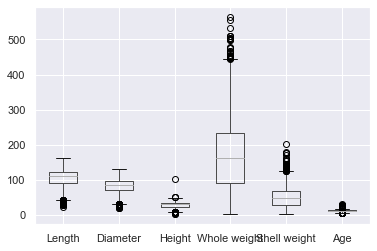

In [151]:
#посмотрим на распределение значений
new_data_x200.boxplot();

In [152]:
#исключим выбросы в данных
#используя метод интерквартильного интервала (IQR).
#IQR вычислим, как разницу между 25-ым и 75-ым перцентилями.
from numpy import percentile
describe_data = new_data_x200.describe()
describe_data = describe_data.drop(['Age'], axis=1)
name_colums = list(describe_data.columns)
clear_data = new_data_x200.copy()
for data in name_colums:
    # вычислим 25 и 75 персентиль
    q25, q75 = percentile(new_data_x200[data], 25), percentile(new_data_x200[data], 75)
    iqr = q75 - q25
    #Теперь мы можем определить область нормальных данных, 
    #умножив IQR на 1,5 (k-фактор), вычесть этот отрезок из 
    #25-ого перцентиля и прибавить к 75-ому - это и будут границы.
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in new_data_x200[data] if x < lower or x > upper]
    clear_data = clear_data[(clear_data[data]>lower)&(clear_data[data]<upper)]
    
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    print('Количество_выбросов: %d' % len(outliers))

Percentiles: 25th=91.000, 75th=123.000, IQR=32.000
Количество_выбросов: 48
Percentiles: 25th=70.000, 75th=96.000, IQR=26.000
Количество_выбросов: 48
Percentiles: 25th=23.000, 75th=33.000, IQR=10.000
Количество_выбросов: 23
Percentiles: 25th=91.200, 75th=232.700, IQR=141.500
Количество_выбросов: 29
Percentiles: 25th=26.900, 75th=66.000, IQR=39.100
Количество_выбросов: 38


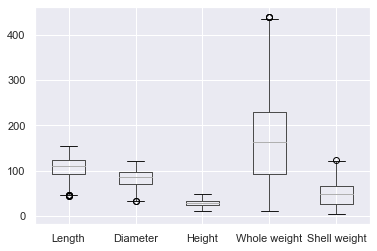

In [153]:
#посмотрим на итог
clear_data.boxplot(column = name_colums);

Имеет ли смысл подвергать преобразованиям числовые признаки? 

In [154]:
#применим к данным Устойчивую нормализация (Robust Scaling)
#так как устойчивая нормализация исключает влияние аномалий
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
final_data = new_data_x200.copy()

numerical_indices = [0, 1, 2, 3, 4]
numerical = []
for i in numerical_indices:
    numerical.append(final_data.columns[i])


scaler = RobustScaler()
for i in numerical:
    ff = np.array(final_data[i]).reshape(-1, 1)
    
    transform_feat = scaler.fit_transform(ff)
    final_data[i] = transform_feat 

In [155]:
# создадим 2 дата сета-для классификации и регрессии
data_clf = final_data.copy()
data_reg = final_data.copy()

#### Классификация

In [156]:
#посмотрим на распределение классов
data_clf['Age'].value_counts()

10.5    662
11.5    620
9.5     542
12.5    478
8.5     368
13.5    260
7.5     237
14.5    199
15.5    126
6.5     102
16.5    100
17.5     66
18.5     58
5.5      48
19.5     42
20.5     31
21.5     26
22.5     14
4.5      12
24.5      9
23.5      6
28.5      2
25.5      2
26.5      1
27.5      1
30.5      1
3.5       1
Name: Age, dtype: int64

In [157]:
# объединим класс 3,5 и 4,5
data_clf['Age'] = np.where(data_clf['Age'] == 3.5, 4.5, data_clf['Age'])

In [158]:
#объединим значения больше 23,5 в один класс
#так как выборка по этим классам слишком мала
data_clf['Age'] = np.where(data_clf['Age'] >= 23.5, 23.5, data_clf['Age'])

In [32]:
#первый вариант -количество классов = 20
#в качестве метрики используем F1
#class_weight = 'balanced' чтобы выровнять дисбаланс классов
import category_encoders
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

f1_scorer = make_scorer(f1_score, average='macro')
new_df = data_clf.copy()
X = new_df.drop(['Age'], axis=1)
y = new_df['Age']
#закодируем классы целевой переменной
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
o = list(le.classes_)
list_of_classes = [str(i) for i in o]
clf = DecisionTreeClassifier(class_weight = 'balanced')
param_grid = {'max_depth': np.arange(15,17),
             'min_samples_split':np.arange(20,22),
             'min_samples_leaf':np.arange(20,22),
              'max_features': np.arange(1,5),
              
              'max_leaf_nodes': np.arange(15,17),
              'min_impurity_decrease': [0.0001,0.00001,0.000001,0.0000001],
              'min_impurity_split': [0.0001,0.00001,0.000001,0.0000001]}
             
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)
grid_search = GridSearchCV(clf, param_grid, cv=5,verbose=0,
                           scoring=f1_scorer)
grid_search.fit(X_train, y_train)


print(("best score from grid search: %.3f"
                   % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)
report = classification_report(grid_search.best_estimator_.predict(X_test), 
                               y_test,target_names = list_of_classes)
print(report)

best score from grid search: 0.104
{'max_depth': 16, 'max_features': 4, 'max_leaf_nodes': 16, 'min_impurity_decrease': 1e-06, 'min_impurity_split': 0.0001, 'min_samples_leaf': 21, 'min_samples_split': 21}
              precision    recall  f1-score   support

         4.5       1.00      0.24      0.38        21
         5.5       0.20      0.21      0.21        14
         6.5       0.43      0.13      0.20        78
         7.5       0.28      0.32      0.30        72
         8.5       0.37      0.20      0.26       189
         9.5       0.00      0.00      0.00         0
        10.5       0.50      0.24      0.33       394
        11.5       0.23      0.22      0.23       203
        12.5       0.00      0.00      0.00         0
        13.5       0.00      0.00      0.00         0
        14.5       0.00      0.00      0.00         0
        15.5       0.00      0.00      0.00         0
        16.5       0.00      0.00      0.00         0
        17.5       0.09      0.07     

In [ ]:
#второй вариант-итоговых 3 класса
#class_weight = None - применяем разделение классов без дисбаланса
import category_encoders
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")


#разделим на 3 класса по принципу
new_df = data_clf.copy()

new_df['Age'] = np.where(new_df['Age'] <= 9.5,1,new_df['Age'])
new_df['Age'] = np.where(((new_df['Age'] > 9.5) & (new_df['Age'] <= 11.5)), 2,new_df['Age'])
new_df['Age'] = np.where(new_df['Age'] > 11.5,3,new_df['Age'])
list_of_classes = ['1','2','3']
X = new_df.drop(['Age'], axis=1)
y = new_df['Age']
clf = DecisionTreeClassifier(class_weight = None)
param_grid = {'max_depth': np.arange(5,8),
             'min_samples_split':np.arange(100,102),
             'min_samples_leaf':np.arange(100,102),
              'max_features': np.arange(1,5),
              
              'max_leaf_nodes': np.arange(15,17),
              'min_impurity_decrease': [0.0001,0.00001,0.000001,0.0000001],
              'min_impurity_split': [0.0001,0.00001,0.000001,0.0000001]}
             
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)
grid_search = GridSearchCV(clf, param_grid, cv=5,verbose=0,
                           scoring=f1_scorer)
grid_search.fit(X_train, y_train)


print(("best score from grid search: %.3f"
                   % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)
report = classification_report(grid_search.best_estimator_.predict(X_test), 
                               y_test,target_names = list_of_classes)
print(report)

#### Теперь рассмотрим задачу регрессии

In [658]:
X = data_reg.drop(['Age'], axis=1)
y = data_reg['Age']
clf = DecisionTreeRegressor()
param_grid = {'max_depth': np.arange(10,12),
             'min_samples_split':np.arange(54,56),
             'min_samples_leaf':np.arange(23,25),
              'max_features': np.arange(1,6),
              
              'max_leaf_nodes': np.arange(28,33),
               'min_impurity_decrease': [0.0001,0.00001,0.000001,0.0000001],
               'min_impurity_split': [0.0001,0.00001,0.000001,0.0000001]}
             
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)
grid_search = GridSearchCV(clf, param_grid, cv=5,verbose=0,
                           scoring='r2',n_jobs=-1)
grid_search.fit(X_train, y_train)


print(("best score from grid search: %.3f"
                   % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

best score from grid search: 0.447
{'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': 31, 'min_impurity_decrease': 1e-06, 'min_impurity_split': 0.0001, 'min_samples_leaf': 23, 'min_samples_split': 55}
